In [1]:
import pandas as pd
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP

from sklearn.metrics import roc_auc_score
from pandarallel import pandarallel

import seaborn as sns
sns.set(style = 'white', font_scale=1.5)
pandarallel.initialize(nb_workers = 8, progress_bar=True) # initialize(36) or initialize(os.cpu_count()-1)

/home/was966/micromamba/envs/RNA/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/was966/micromamba/envs/RNA/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/was966/micromamba/envs/RNA/lib/python3.11/site-packages/umap/distanc

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/home/was966/micromamba/envs/RNA/lib/python3.11/site-packages/umap/umap_.py:660: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()


In [2]:
import sys
sys.path.insert(0, '/home/was966/Research/PSOG/')
from gdd.correlation import pairwise_correlation
from gdd.combination import pairwise_combination
from gdd.score import Xy_score
from gdd.plot import plot_batch
BEST = ['PIK3CD', 'TOLLIP']

In [3]:
data_path = '/n/data1/hms/dbmi/zitnik/lab/users/was966/ITRP/TCGA-ITRP-MERGE/735'

tcga_tpm = pd.read_pickle(os.path.join(data_path, 'TPM.TCGA.TABLE'))
itrp_tpm = pd.read_pickle(os.path.join(data_path, 'TPM.ITRP.TABLE'))
itrp_tpm_crt = pd.read_pickle(os.path.join(data_path, 'TPM.ITRP.TABLE.CORRECT'))

tcga_patient = pd.read_pickle(os.path.join(data_path, 'PATIENT.TCGA.TABLE'))
tcga_patient['cohort'] = tcga_patient.cancer_type
itrp_patient = pd.read_pickle(os.path.join(data_path, 'PATIENT.ITRP.TABLE'))
gene = pd.read_pickle(os.path.join(data_path, 'GENE.TABLE'))

dfp1 = itrp_tpm.join(itrp_patient.cohort)
dfp2 = tcga_tpm.join(tcga_patient.cohort)
dfp2 = dfp2[dfp2.cohort == 'TCGA-SKCM']
dfp = pd.concat([dfp1, dfp2])

UMAP(random_state=42, spread=2, verbose=1)
Thu Sep  7 20:55:28 2023 Construct fuzzy simplicial set
Thu Sep  7 20:55:28 2023 Finding Nearest Neighbors
Thu Sep  7 20:55:32 2023 Finished Nearest Neighbor Search
Thu Sep  7 20:55:35 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Thu Sep  7 20:55:37 2023 Finished embedding


<Axes: xlabel='UMAP1', ylabel='UMAP2'>

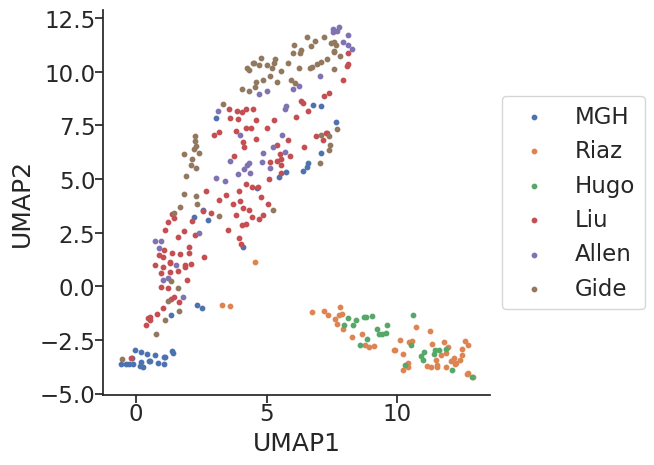

In [4]:
plot_batch(dfp1,  batch_col='cohort')

<Axes: xlabel='CD3E', ylabel='CMKLR1'>

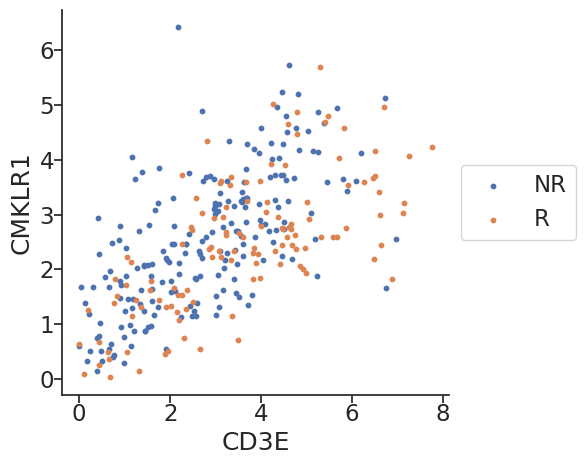

In [18]:
plot_batch(dfp1[['CD3E','CMKLR1']].join(itrp_patient.RECIST_Response),  batch_col='RECIST_Response')

<Axes: xlabel='PIK3CD', ylabel='TOLLIP'>

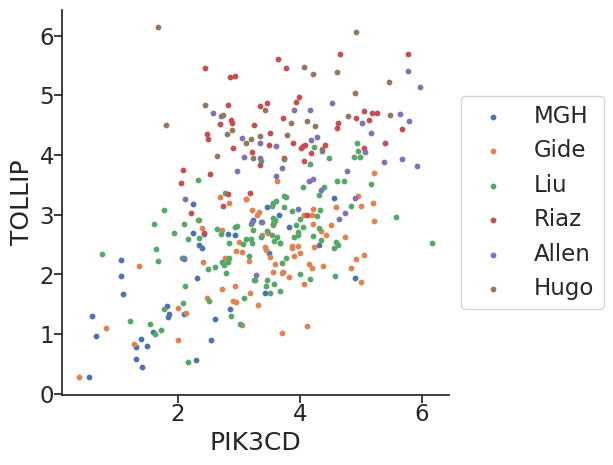

In [6]:
plot_batch(dfp1[BEST].join(itrp_patient.cohort),  batch_col='cohort')

In [7]:
pc = pairwise_combination(combination_pairs = [], n_cpus=8, method='subtraction')
pc = pc.fit(itrp_tpm)

In [8]:
itrp_tpm_cmb = pc.transform()
itrp_tpm_cmb_inverse = pc.inverse(itrp_tpm_cmb)

100%|##########| 269745/269745 [00:51<00:00, 5221.88it/s]


In [10]:
y_col = 'Freeman_response'
dfxy = itrp_tpm_cmb.join(itrp_tpm_cmb_inverse).join(itrp_patient[y_col])
mic = Xy_score(dfxy, y_col, method='mic', n_jobs=6)
prc = Xy_score(dfxy, y_col, method='prc', n_jobs=6)
roc = Xy_score(dfxy, y_col, method='roc', n_jobs=6)

100%|##########| 539490/539490 [03:09<00:00, 2839.64it/s]


In [31]:
score = mic.join(prc).join(roc)
score['mean'] = score.mean(axis=1)
score = score.sort_values('roc')

In [32]:
dfxy1 = itrp_tpm.join(itrp_patient[y_col])
mic1 = Xy_score(dfxy1, y_col, method='mic', n_jobs=6)
prc1 = Xy_score(dfxy1, y_col, method='prc', n_jobs=6)
roc1 = Xy_score(dfxy1, y_col, method='roc', n_jobs=6)

100%|##########| 735/735 [00:00<00:00, 4348.37it/s]


In [33]:
score1 = mic1.join(prc1).join(roc1)
score1['mean'] = score1.mean(axis=1)
score1 = score1.sort_values('roc')

In [39]:
score1.tail(10)

,mic,prc,roc,mean
gene_name,,,,
IL21,0.057129,0.572189,0.620767,0.416695
NCR1,0.030978,0.571760,0.620878,0.407872
PRF1,0.022237,0.541952,0.622098,0.395429
ITK,0.000000,0.560958,0.622098,0.394352
CD96,0.000000,0.562583,0.622449,0.395011
IL7R,0.066789,0.565036,0.627588,0.419804
LILRA4,0.037552,0.561523,0.629640,0.409572
CD3G,0.099655,0.584466,0.630213,0.438111
CD3D,0.056716,0.592053,0.631359,0.426709


In [38]:
score.tail(10)

,mic,prc,roc,mean
gene_name,,,,
CD3E - IL18,0.048486,0.632331,0.684783,0.455200
PRF1 - F2RL1,0.059242,0.594462,0.684857,0.446187
CD3E - CMKLR1,0.112912,0.645925,0.686816,0.481884
LILRA4 - SERPINB2,0.060801,0.611244,0.687555,0.453200
ICOS - F2RL1,0.056790,0.605689,0.689034,0.450504
PRF1 - CMKLR1,0.045381,0.583941,0.689959,0.439760
LILRB1 - CMKLR1,0.089531,0.634156,0.692787,0.472158
CLEC4C - SERPINB2,0.097508,0.589679,0.693471,0.460219
CCR4 - F2RL1,0.055204,0.648428,0.698721,0.467451


<Axes: xlabel='cohort', ylabel='CD3E'>

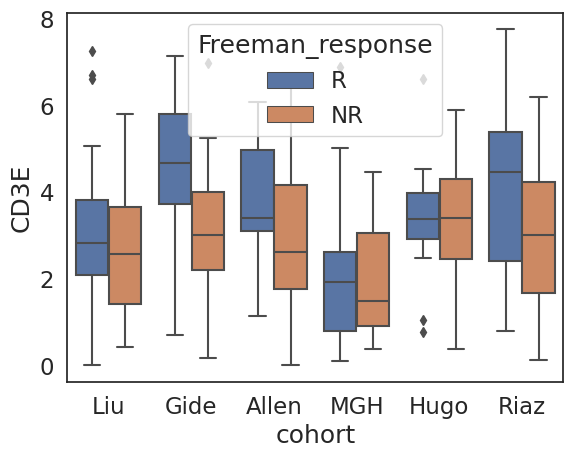

In [40]:
yc = 'CD3E'
dfpp = dfxy1.join(itrp_patient.cohort)[[yc, 'cohort', y_col]]
sns.boxplot(dfpp,y = yc, x = 'cohort', hue = y_col)

<Axes: xlabel='cohort', ylabel='PIK3CD - TOLLIP'>

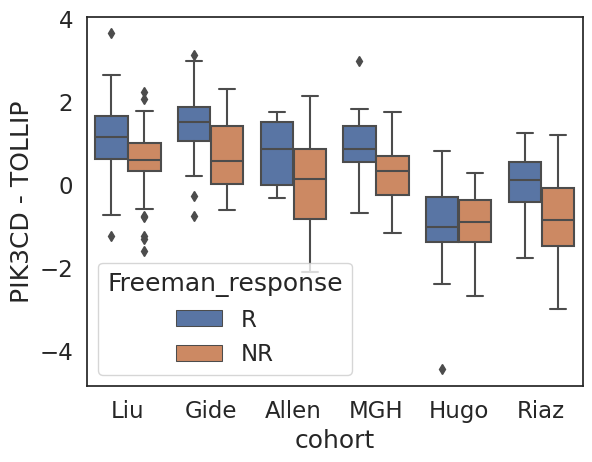

In [41]:
yc = 'PIK3CD - TOLLIP'
dfpp = dfxy.join(itrp_patient.cohort)[[yc, 'cohort', y_col]]
sns.boxplot(dfpp,y = yc, x = 'cohort', hue = y_col)

In [44]:
tcga_corr = pairwise_correlation(tcga_tpm.values, method = 'pearson')

the number of process is 8


100%|##########| 269745/269745 [00:00<00:00, 1409178.19it/s]


In [ ]:
tcga_mir = pairwise_correlation(tcga_tpm.values, method = 'mutual_info')

the number of process is 8


 14%|#4        | 38499/269745 [05:33<30:53, 124.77it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

 36%|###6      | 97184/269745 [14:03<24:43, 116.32it/s]